<a href="https://colab.research.google.com/github/esholmess/Skin-Disease-Detection-with-Computer-Vision/blob/main/dice_loss_attention_unet_training(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

from google.colab import files
import zipfile


In [11]:
uploaded = files.upload()

Saving kto data.zip to kto data (1).zip


In [19]:
with zipfile.ZipFile("kto data (1).zip", 'r') as zip_ref:
    zip_ref.extractall("final_data")

In [13]:

class Dataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("L")
        mask = Image.open(os.path.join(self.mask_dir, self.images[idx])).convert("L")
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask.float()


In [20]:

image_dir = "final_data/kto data/images"
mask_dir = "final_data/kto data/masks"


image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))
assert set(image_files) == set(mask_files)
train_imgs, test_imgs = train_test_split(image_files, test_size=0.4, random_state=42)

os.makedirs("data/train/images", exist_ok=True)
os.makedirs("data/train/masks", exist_ok=True)
os.makedirs("data/test/images", exist_ok=True)
os.makedirs("data/test/masks", exist_ok=True)

def move_files(file_list, src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir):
    for file in file_list:
        shutil.copy(os.path.join(src_img_dir, file), os.path.join(dst_img_dir, file))
        shutil.copy(os.path.join(src_mask_dir, file), os.path.join(dst_mask_dir, file))

move_files(train_imgs, image_dir, mask_dir, "data/train/images", "data/train/masks")
move_files(test_imgs, image_dir, mask_dir, "data/test/images", "data/test/masks")

print("Train/test klasörleri oluşturuldu ve dosyalar kopyalandı.")


Train/test klasörleri oluşturuldu ve dosyalar kopyalandı.


In [29]:
from torchvision import transforms
from torch.utils.data import DataLoader




train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),

])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



train_dataset = Dataset("data/train/images", "data/train/masks", transform=train_transform)
test_dataset  = Dataset("data/test/images", "data/test/masks", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [26]:

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

def dice_coef(preds, targets, smooth=1.0):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    total = (preds + targets).sum()
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

def binary_accuracy(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    return (preds == targets).float().mean()

def precision_recall_f1(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    TP = (preds * targets).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision.item(), recall.item(), f1.item()


In [27]:

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        self.conv_1x1_output = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv_1x1_output(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNetAttentionASPP(nn.Module):
    def __init__(self):
        super(UNetAttentionASPP, self).__init__()
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ASPP(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionGate(512, 512, 256)
        self.dec4 = ConvBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(128, 128, 64)
        self.dec2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionGate(64, 64, 32)
        self.dec1 = ConvBlock(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.up4(b)
        e4 = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.up3(d4)
        e3 = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        e2 = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        e1 = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        return torch.sigmoid(self.final(d1))


100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Epoch 1 Loss: 0.5969


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 2 Loss: 0.5493


100%|██████████| 82/82 [00:43<00:00,  1.86it/s]


Epoch 3 Loss: 0.5339


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 4 Loss: 0.5184


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 5 Loss: 0.5097


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 6 Loss: 0.5028


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 7 Loss: 0.4931


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 8 Loss: 0.4982


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 9 Loss: 0.4878


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 10 Loss: 0.4824


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 11 Loss: 0.4813


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 12 Loss: 0.4772


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 13 Loss: 0.4767


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 14 Loss: 0.4728


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 15 Loss: 0.4723


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 16 Loss: 0.4726


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 17 Loss: 0.4663


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 18 Loss: 0.4690


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 19 Loss: 0.4663


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 20 Loss: 0.4643


100%|██████████| 82/82 [00:43<00:00,  1.86it/s]


Epoch 21 Loss: 0.4667


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 22 Loss: 0.4653


100%|██████████| 82/82 [00:44<00:00,  1.86it/s]


Epoch 23 Loss: 0.4595


100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Epoch 24 Loss: 0.4585


100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Epoch 25 Loss: 0.4604


100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Epoch 26 Loss: 0.4612


100%|██████████| 82/82 [00:44<00:00,  1.86it/s]


Epoch 27 Loss: 0.4616


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 28 Loss: 0.4612


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 29 Loss: 0.4565


100%|██████████| 82/82 [00:44<00:00,  1.86it/s]


Epoch 30 Loss: 0.4570


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 31 Loss: 0.4528


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 32 Loss: 0.4594


100%|██████████| 82/82 [00:44<00:00,  1.86it/s]


Epoch 33 Loss: 0.4585


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 34 Loss: 0.4536


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 35 Loss: 0.4517


100%|██████████| 82/82 [00:43<00:00,  1.88it/s]


Epoch 36 Loss: 0.4568


100%|██████████| 82/82 [00:44<00:00,  1.86it/s]


Epoch 37 Loss: 0.4484


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 38 Loss: 0.4558


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 39 Loss: 0.4504


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 40 Loss: 0.4557


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 41 Loss: 0.4597


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 42 Loss: 0.4573


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 43 Loss: 0.4511


100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Epoch 44 Loss: 0.4522


100%|██████████| 82/82 [00:43<00:00,  1.86it/s]


Epoch 45 Loss: 0.4566


100%|██████████| 82/82 [00:44<00:00,  1.86it/s]


Epoch 46 Loss: 0.4558


100%|██████████| 82/82 [00:44<00:00,  1.86it/s]


Epoch 47 Loss: 0.4543


100%|██████████| 82/82 [00:43<00:00,  1.87it/s]


Epoch 48 Loss: 0.4510


100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Epoch 49 Loss: 0.4470


100%|██████████| 82/82 [00:43<00:00,  1.86it/s]


Epoch 50 Loss: 0.4502
Dice: 0.5535  IoU: 0.3827  Accuracy: 0.2551  Precision: 0.4460  Recall: 0.7313


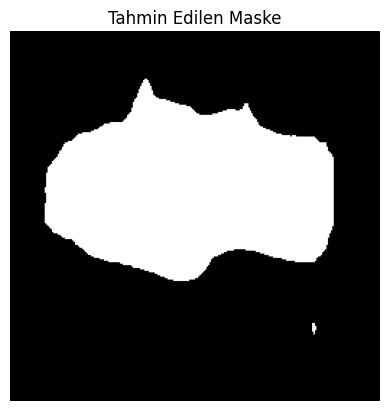

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetAttentionASPP().to(device)
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(50):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

# Değerlendirme
model.eval()
with torch.no_grad():
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        dice = dice_coef(preds, masks)
        iou = iou_score(preds, masks)
        acc = binary_accuracy(preds, masks)
        p, r, f1 = precision_recall_f1(preds, masks)
        print(f"Dice: {dice:.4f}  IoU: {iou:.4f}  Accuracy: {acc:.4f}  Precision: {p:.4f}  Recall: {r:.4f}")
        break
#save model
save_dir = "kto_model"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def infer_single_image(model, image_path, device):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert("L")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = (output > 0.5).float().squeeze().cpu().numpy()

    plt.imshow(pred_mask, cmap='gray')
    plt.title("Tahmin Edilen Maske")
    plt.axis('off')
    plt.show()

    return pred_mask

infer_single_image(model, "data/test/images/jsrt-JPCLN003.png", device)

In [ ]:
login(token="HF_...")  # kendi token’ını buraya yaz
repo_id = "my-org/kto-unet-model"  # organizasyonuna ait repo adı

upload_folder(
    repo_id=repo_id,
    folder_path=save_dir,
    repo_type="model"
)